In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
df_train = pd.read_csv("data/churn_train.csv")
df_test = pd.read_csv("data/churn_test.csv")

In [3]:
def replace_nans(df):
    # replace Nan with mean 
    avg_rating_by_driver_mean = np.mean(df["avg_rating_by_driver"])
    avg_rating_of_driver_mean = np.mean(df["avg_rating_of_driver"])
    df["avg_rating_by_driver"].fillna(avg_rating_by_driver_mean, inplace=True)
    df["avg_rating_of_driver"].fillna(avg_rating_of_driver_mean, inplace=True)

In [4]:
def clean_data(df):
    df1 = df[~pd.isnull(df).any(axis=1)]
    # creat dummy vars for [city, phone]
    df2 = pd.get_dummies(df1, columns=['city','phone'], drop_first=False)
    # Add dates
    df2["signup_date"] = pd.to_datetime(df2["signup_date"])
    df2["last_trip_date"] = pd.to_datetime(df2["last_trip_date"])
    df2["Days Active"] =  (df2["last_trip_date"]-df2["signup_date"]).dt.days
    # Add target
    df2["target"] = df2["last_trip_date"]>pd.Timestamp("2014-06-01")
    return df2

In [5]:
replace_nans(df_train)
replace_nans(df_test)
df_train = clean_data(df_train)
df_test = clean_data(df_test)

In [6]:
df_train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,Days Active,target
0,6.94,5.0,5.000000,1.00,2014-05-03,2014-01-12,0.0,0,False,100.0,1,0,0,1,0,111,False
1,8.06,5.0,5.000000,1.00,2014-01-26,2014-01-25,0.0,2,True,0.0,1,0,0,1,0,1,False
2,21.50,4.0,4.601697,1.00,2014-05-21,2014-01-02,0.0,1,True,100.0,0,0,1,0,1,139,False
3,9.46,5.0,4.601697,2.75,2014-01-10,2014-01-09,100.0,1,False,100.0,0,0,1,1,0,1,False
4,13.77,5.0,4.601697,1.00,2014-05-13,2014-01-31,0.0,0,False,100.0,0,0,1,0,1,102,False


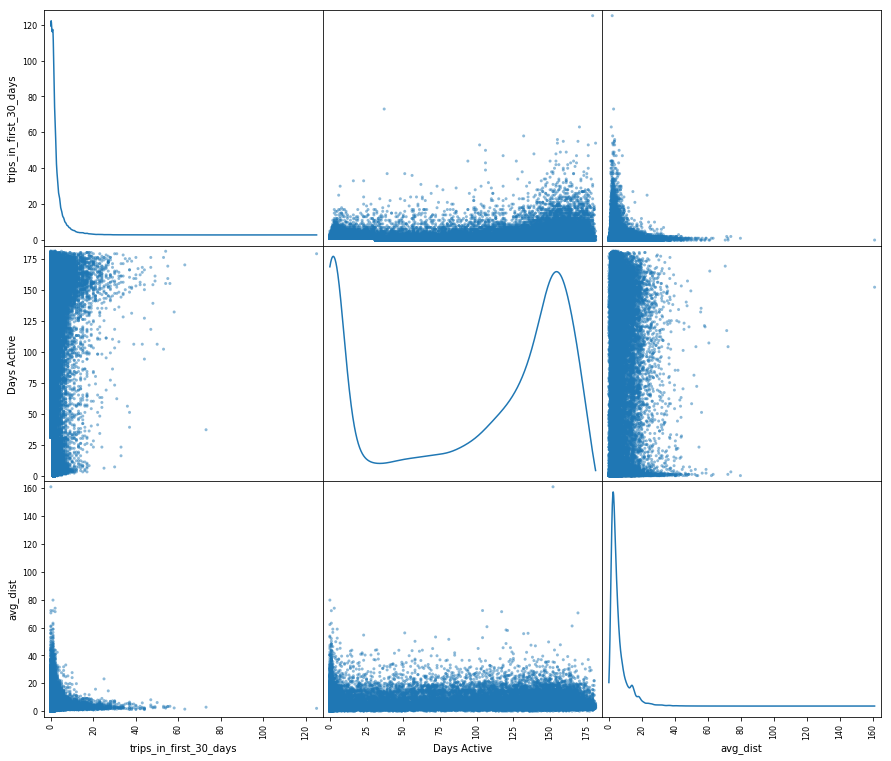

In [7]:
from pandas.plotting import scatter_matrix
df_scat = pd.DataFrame(df_train, columns=["trips_in_first_30_days", "Days Active", "avg_dist"])
scatter_matrix(df_scat,figsize=(15, 13), diagonal="kde")
plt.show()

In [8]:
y = df_train.pop("target").values
df_train.drop(["last_trip_date","signup_date","Days Active"], axis=1, inplace=True)
X = df_train.values

In [9]:
# Gradient Boosting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .25)
gb = GradientBoostingClassifier(learning_rate=0.1, 
                                n_estimators=200, 
                                subsample=0.5,
                                min_samples_split=3,
                                min_weight_fraction_leaf=0.001,
                                min_samples_leaf=50, 
                                max_depth=4)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [10]:
# param_grid = {"n_estimators":[200],
#               "learning_rate":[.1],
#               "subsample":[.5],
#               "max_depth":[3],
#               "min_samples_leaf":[3],
#               "min_samples_split":[2]
#              }
# gs = GridSearchCV(gb, param_grid = param_grid, n_jobs=-1)
# gb_best = gs.best_estimator_
# y_pred = gb_best.predict(X_test)

In [11]:
cm = metrics.confusion_matrix(y_test,y_pred)
acc = metrics.accuracy_score(y_test,y_pred)

In [12]:
acc

0.79729865940933375

In [13]:
df_test.columns[np.argsort(gb.feature_importances_)[::-1]]

Index(['avg_dist', 'trips_in_first_30_days', 'signup_date', 'last_trip_date',
       'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'weekday_pct', 'surge_pct', 'luxury_car_user', 'city_Winterfell',
       'city_King's Landing', 'city_Astapor'],
      dtype='object')

In [14]:
feature_scores = gb.feature_importances_[np.argsort(gb.feature_importances_)[::-1]]

In [15]:
feature_scores

array([ 0.21779985,  0.18258657,  0.10715495,  0.10340309,  0.09810179,
        0.09154491,  0.06666623,  0.03729723,  0.03226699,  0.02232037,
        0.01740476,  0.01498582,  0.00846743])

In [16]:
y = df_test.pop("target").values
df_test.drop(["last_trip_date","signup_date","Days Active"], axis=1, inplace=True)
X = df_test.values

In [17]:
y_pred_test = gb.predict(X)

In [18]:
cm = metrics.confusion_matrix(y,y_pred_test)
acc = metrics.accuracy_score(y,y_pred_test)
acc

0.78655648493399177

In [19]:
cm

array([[5441,  841],
       [1277, 2364]])

In [21]:
scores = gb.predict_proba(X)

In [22]:
scores.shape

(9923, 2)

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(y, scores[:,0], pos_label=1)

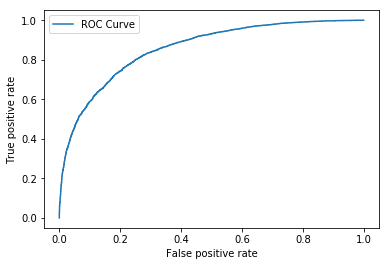

In [31]:
plt.plot(tpr, fpr, label="ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()